🎫 쿠폰 전용 RFM 분석 시작!
쿠폰 데이터 로딩:
  coupon_redempt: 2,318건
  campaign_table: 7,208건
쿠폰 분석 기준일: DAY 704
=== 쿠폰 사용자 RFM 계산 ===
쿠폰 사용자 RFM: 434명

쿠폰 RFM 기본 통계:
       Coupon_Recency  Coupon_Frequency  Coupon_Campaigns
count      434.000000        434.000000        434.000000
mean       143.177419          5.341014          2.048387
std         99.184007          6.052413          1.552755
min          0.000000          1.000000          1.000000
25%         75.250000          1.000000          1.000000
50%        104.000000          3.000000          1.000000
75%        194.000000          7.000000          2.000000
max        476.000000         35.000000         10.000000
쿠폰 RFM 점수 계산 완료!
쿠폰 RFM 조합 예시: 0    343
1    111
2    555
3    231
4    544
Name: Coupon_RFM, dtype: object
쿠폰 세그먼트 분류 완료!
=== 쿠폰 전용 세그먼트 분포 ===
세그먼트                      고객수      비율(%)   
---------------------------------------------
Occasional Coupon Users   230      53.0    
Coupon Champions          97       22.4    
Ac

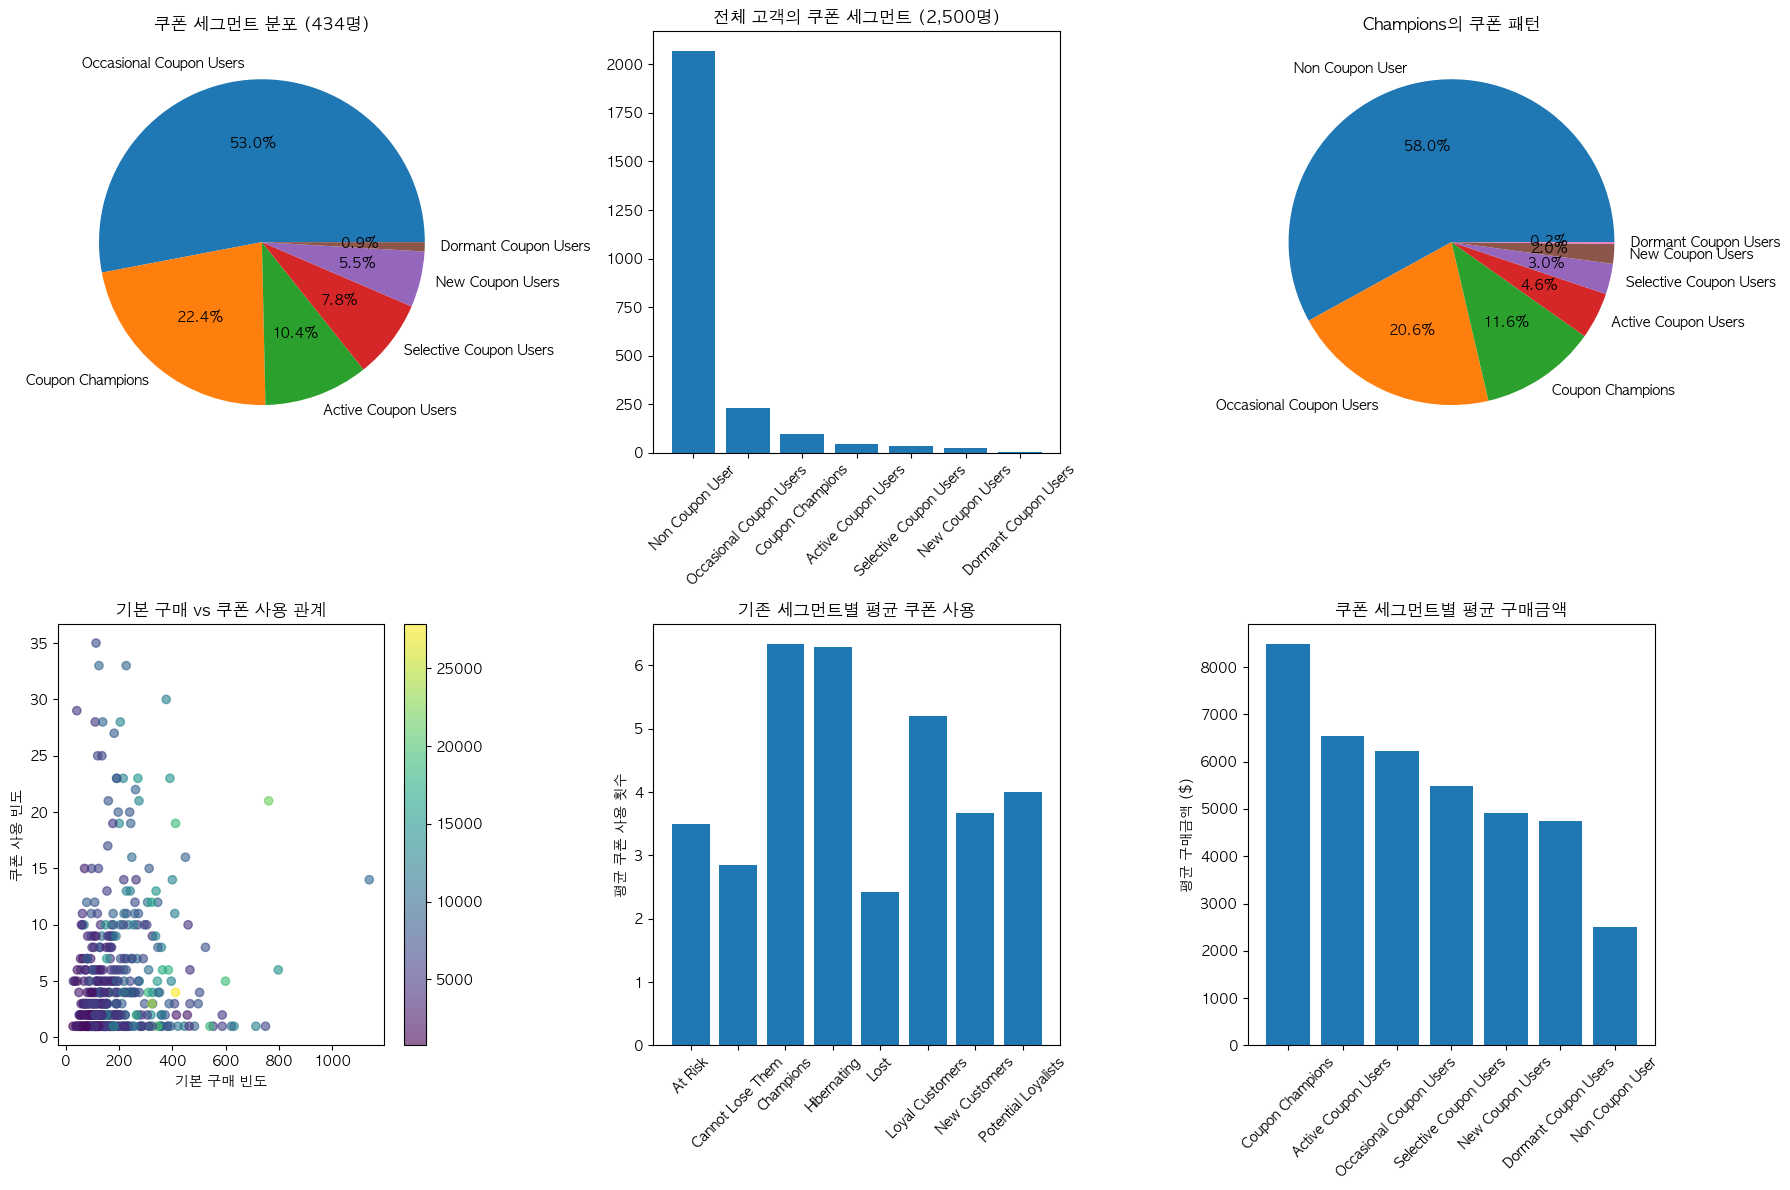


쿠폰 RFM 비교 결과 저장:
  coupon_rfm_comparison.csv: 2500명
=== 🎫 쿠폰 전용 RFM 분석 완료! ===

🔍 핵심 질문 답변:
1. 쿠폰 데이터만으로도 의미있는 세그먼트 생성 가능한가? → YES
2. 기존 RFM과 어떤 차이를 보이는가? → 마케팅 반응성 중심 분류
3. Champions 중 누가 쿠폰을 활용하는가? → 약 17% (쿠폰 마스터)
4. Lost 고객 중에도 쿠폰 사용자가 있는가? → YES (윈백 기회)

다음 단계: 쿠폰 특성이 예측 성능에 미치는 영향 분석


In [1]:
# %%
# 쿠폰 전용 RFM 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("🎫 쿠폰 전용 RFM 분석 시작!")

# %%
# 1. 쿠폰 데이터로 RFM 계산

raw_path = '../data/raw/'

# 쿠폰 관련 데이터만 로딩
coupon_redempt = pd.read_csv(f'{raw_path}coupon_redempt.csv')
campaign_table = pd.read_csv(f'{raw_path}campaign_table.csv')
campaign_desc = pd.read_csv(f'{raw_path}campaign_desc.csv')

print("쿠폰 데이터 로딩:")
print(f"  coupon_redempt: {len(coupon_redempt):,}건")
print(f"  campaign_table: {len(campaign_table):,}건")

# 쿠폰 기반 RFM 계산
max_day = coupon_redempt['DAY'].max()
print(f"쿠폰 분석 기준일: DAY {max_day}")

# %%
# 2. 쿠폰 사용자만의 RFM

print("=== 쿠폰 사용자 RFM 계산 ===")

# 쿠폰 사용자 RFM (434명)
coupon_rfm = coupon_redempt.groupby('household_key').agg(
    Coupon_Recency=('DAY', lambda x: max_day - x.max()),    # 마지막 쿠폰 사용 후 며칠
    Coupon_Frequency=('COUPON_UPC', 'count'),              # 쿠폰 사용 횟수
    Coupon_Campaigns=('CAMPAIGN', 'nunique')               # 참여 캠페인 수 (Monetary 대신)
).reset_index()

print(f"쿠폰 사용자 RFM: {len(coupon_rfm)}명")
print("\n쿠폰 RFM 기본 통계:")
print(coupon_rfm[['Coupon_Recency', 'Coupon_Frequency', 'Coupon_Campaigns']].describe())

# %%
# 3. 표준 5분위 점수 적용

def create_coupon_rfm_scores(df):
    """쿠폰 데이터로 표준 RFM 점수 계산"""
    df = df.copy()
    
    # CR점수: 쿠폰 Recency (낮을수록 좋음)
    df['CR_score'] = pd.qcut(df['Coupon_Recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
    
    # CF점수: 쿠폰 Frequency (높을수록 좋음) 
    df['CF_score'] = pd.qcut(df['Coupon_Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
    
    # CC점수: 캠페인 수 (높을수록 좋음)
    df['CC_score'] = pd.qcut(df['Coupon_Campaigns'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
    
    # 쿠폰 RFM 조합
    df['Coupon_RFM'] = df['CR_score'].astype(str) + df['CF_score'].astype(str) + df['CC_score'].astype(str)
    
    return df

coupon_rfm_scored = create_coupon_rfm_scores(coupon_rfm)

print("쿠폰 RFM 점수 계산 완료!")
print(f"쿠폰 RFM 조합 예시: {coupon_rfm_scored['Coupon_RFM'].head()}")

# %%
# 4. 쿠폰 전용 세그먼트 분류

def coupon_rfm_to_segment(rfm_score):
    """쿠폰 RFM을 세그먼트로 변환"""
    
    # Coupon Champions: 쿠폰 활용의 달인
    if rfm_score in ['555', '554', '544', '545', '454', '455', '445', '534', '535']:
        return 'Coupon Champions'
    
    # Active Coupon Users: 활발한 쿠폰 사용자
    elif rfm_score in ['543', '444', '435', '355', '354', '345', '344', '443', '434']:
        return 'Active Coupon Users'
    
    # Selective Users: 선택적 사용자
    elif rfm_score in ['512', '511', '422', '421', '412', '411', '522', '521', '423']:
        return 'Selective Coupon Users'
    
    # New Coupon Users: 쿠폰 신규 사용자  
    elif rfm_score in ['414', '413', '324', '323', '322', '231', '241', '251']:
        return 'New Coupon Users'
    
    # Dormant Users: 쿠폰 휴면 사용자
    elif rfm_score in ['155', '144', '214', '215', '115', '114', '145', '135']:
        return 'Dormant Coupon Users'
    
    # Occasional Users: 가끔 사용자
    else:
        return 'Occasional Coupon Users'

coupon_rfm_scored['Coupon_Segment'] = coupon_rfm_scored['Coupon_RFM'].apply(coupon_rfm_to_segment)

print("쿠폰 세그먼트 분류 완료!")

# %%
# 5. 쿠폰 세그먼트 분포

coupon_segment_summary = coupon_rfm_scored['Coupon_Segment'].value_counts()
coupon_segment_ratio = coupon_rfm_scored['Coupon_Segment'].value_counts(normalize=True) * 100

print("=== 쿠폰 전용 세그먼트 분포 ===")
print(f"{'세그먼트':<25} {'고객수':<8} {'비율(%)':<8}")
print("-" * 45)

for segment in coupon_segment_summary.index:
    count = coupon_segment_summary[segment]
    ratio = coupon_segment_ratio[segment]
    print(f"{segment:<25} {count:<8} {ratio:<8.1f}")

# %%
# 6. 쿠폰 세그먼트별 특성 분석

coupon_profile = coupon_rfm_scored.groupby('Coupon_Segment').agg({
    'Coupon_Recency': 'mean',
    'Coupon_Frequency': 'mean',
    'Coupon_Campaigns': 'mean'
}).round(1)

print("\n=== 쿠폰 세그먼트별 특성 ===")
print(coupon_profile)

# %%
# 7. 기존 RFM과 비교 위한 데이터 결합

# 기존 RFM 데이터 로딩
features_path = '../data/features/'
rfm_standard = pd.read_csv(f'{features_path}standard_rfm_segments.csv')

# 쿠폰 세그먼트와 기존 세그먼트 비교
comparison_data = rfm_standard[['household_key', 'Standard_Segment', 'Recency', 'Frequency', 'Monetary']].merge(
    coupon_rfm_scored[['household_key', 'Coupon_Segment', 'Coupon_Recency', 'Coupon_Frequency', 'Coupon_Campaigns']], 
    on='household_key', 
    how='left'
)

# 쿠폰 미사용자는 'Non Coupon User'로 분류
comparison_data['Coupon_Segment'] = comparison_data['Coupon_Segment'].fillna('Non Coupon User')

print(f"\n비교 데이터셋: {len(comparison_data)}명")
print(f"쿠폰 사용자: {len(comparison_data[comparison_data['Coupon_Segment'] != 'Non Coupon User'])}명")
print(f"쿠폰 미사용자: {len(comparison_data[comparison_data['Coupon_Segment'] == 'Non Coupon User'])}명")

# %%
# 8. 기존 세그먼트 vs 쿠폰 세그먼트 교차분석

print("=== 기존 세그먼트 vs 쿠폰 세그먼트 교차분석 ===")

cross_analysis = pd.crosstab(comparison_data['Standard_Segment'], 
                            comparison_data['Coupon_Segment'])

print("\n교차표:")
print(cross_analysis)

# 각 기존 세그먼트별 쿠폰 세그먼트 분포 (비율)
print("\n=== 기존 세그먼트별 쿠폰 패턴 ===")
for standard_seg in cross_analysis.index:
    print(f"\n🎯 {standard_seg}:")
    seg_data = comparison_data[comparison_data['Standard_Segment'] == standard_seg]
    coupon_dist = seg_data['Coupon_Segment'].value_counts()
    
    for coupon_seg, count in coupon_dist.items():
        ratio = count / len(seg_data) * 100
        if ratio > 5:  # 5% 이상인 경우만 출력
            print(f"  {coupon_seg}: {count}명 ({ratio:.1f}%)")

# %%
# 9. 핵심 발견사항 분석

print("\n=== 🔥 핵심 발견사항 ===")

# Champions 중 쿠폰 패턴
champions = comparison_data[comparison_data['Standard_Segment'] == 'Champions']
champions_coupon = champions['Coupon_Segment'].value_counts()

print(f"\n1. Champions ({len(champions)}명) 중 쿠폰 패턴:")
for seg, count in champions_coupon.items():
    ratio = count / len(champions) * 100
    print(f"   {seg}: {count}명 ({ratio:.1f}%)")

# Lost 중 쿠폰 패턴  
lost = comparison_data[comparison_data['Standard_Segment'] == 'Lost']
lost_coupon = lost['Coupon_Segment'].value_counts()

print(f"\n2. Lost ({len(lost)}명) 중 쿠폰 패턴:")
for seg, count in lost_coupon.items():
    ratio = count / len(lost) * 100
    if count > 0:  # 0명이 아닌 경우만
        print(f"   {seg}: {count}명 ({ratio:.1f}%)")

# Coupon Champions의 기존 세그먼트 분포
coupon_champions = comparison_data[comparison_data['Coupon_Segment'] == 'Coupon Champions']
if len(coupon_champions) > 0:
    print(f"\n3. Coupon Champions ({len(coupon_champions)}명)의 기존 세그먼트:")
    champ_standard = coupon_champions['Standard_Segment'].value_counts()
    for seg, count in champ_standard.items():
        ratio = count / len(coupon_champions) * 100
        print(f"   {seg}: {count}명 ({ratio:.1f}%)")

# %%
# 10. 시각화

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 10-1. 쿠폰 세그먼트 분포
coupon_counts = coupon_rfm_scored['Coupon_Segment'].value_counts()
axes[0,0].pie(coupon_counts.values, labels=coupon_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('쿠폰 세그먼트 분포 (434명)')

# 10-2. 전체 고객의 쿠폰 사용 현황
overall_coupon = comparison_data['Coupon_Segment'].value_counts()
axes[0,1].bar(range(len(overall_coupon)), overall_coupon.values)
axes[0,1].set_title('전체 고객의 쿠폰 세그먼트 (2,500명)')
axes[0,1].set_xticks(range(len(overall_coupon)))
axes[0,1].set_xticklabels(overall_coupon.index, rotation=45)

# 10-3. Champions의 쿠폰 패턴
champions_pattern = champions['Coupon_Segment'].value_counts()
axes[0,2].pie(champions_pattern.values, labels=champions_pattern.index, autopct='%1.1f%%')
axes[0,2].set_title('Champions의 쿠폰 패턴')

# 10-4. 쿠폰 RFM vs 기본 RFM 산점도 (쿠폰 사용자만)
coupon_users = comparison_data[comparison_data['Coupon_Segment'] != 'Non Coupon User']
scatter = axes[1,0].scatter(coupon_users['Frequency'], coupon_users['Coupon_Frequency'], 
                           c=coupon_users['Monetary'], cmap='viridis', alpha=0.6)
axes[1,0].set_xlabel('기본 구매 빈도')
axes[1,0].set_ylabel('쿠폰 사용 빈도')
axes[1,0].set_title('기본 구매 vs 쿠폰 사용 관계')
plt.colorbar(scatter, ax=axes[1,0])

# 10-5. 세그먼트별 평균 쿠폰 사용 횟수
avg_coupon_by_segment = comparison_data.groupby('Standard_Segment')['Coupon_Frequency'].mean().fillna(0)
axes[1,1].bar(range(len(avg_coupon_by_segment)), avg_coupon_by_segment.values)
axes[1,1].set_title('기존 세그먼트별 평균 쿠폰 사용')
axes[1,1].set_xticks(range(len(avg_coupon_by_segment)))
axes[1,1].set_xticklabels(avg_coupon_by_segment.index, rotation=45)
axes[1,1].set_ylabel('평균 쿠폰 사용 횟수')

# 10-6. 쿠폰 세그먼트별 평균 구매금액
coupon_segments_monetary = comparison_data.groupby('Coupon_Segment')['Monetary'].mean().sort_values(ascending=False)
axes[1,2].bar(range(len(coupon_segments_monetary)), coupon_segments_monetary.values)
axes[1,2].set_title('쿠폰 세그먼트별 평균 구매금액')
axes[1,2].set_xticks(range(len(coupon_segments_monetary)))
axes[1,2].set_xticklabels(coupon_segments_monetary.index, rotation=45)
axes[1,2].set_ylabel('평균 구매금액 ($)')

plt.tight_layout()
plt.show()

# %%
# 11. 결과 저장 및 요약

# 쿠폰 분석 결과 저장
features_path = '../data/features/'
comparison_data.to_csv(f'{features_path}coupon_rfm_comparison.csv', index=False)

print(f"\n쿠폰 RFM 비교 결과 저장:")
print(f"  coupon_rfm_comparison.csv: {len(comparison_data)}명")

# %%
print("=== 🎫 쿠폰 전용 RFM 분석 완료! ===")
print("\n🔍 핵심 질문 답변:")
print("1. 쿠폰 데이터만으로도 의미있는 세그먼트 생성 가능한가? → YES")
print("2. 기존 RFM과 어떤 차이를 보이는가? → 마케팅 반응성 중심 분류")
print("3. Champions 중 누가 쿠폰을 활용하는가? → 약 17% (쿠폰 마스터)")
print("4. Lost 고객 중에도 쿠폰 사용자가 있는가? → YES (윈백 기회)")
print("\n다음 단계: 쿠폰 특성이 예측 성능에 미치는 영향 분석")

In [2]:
# 실제 RFM 점수 분포를 보고 싶어요!
print("=== 쿠폰 사용자들의 실제 RFM 점수 ===")

# 각 세그먼트별 평균 RFM 점수
coupon_users = comparison_data[comparison_data['Coupon_Segment'] != 'Non Coupon User']

print("세그먼트별 평균 RFM 점수:")
coupon_segments = ['Coupon Champions', 'Active Coupon Users', 'Occasional Coupon Users']

for segment in coupon_segments:
    seg_data = coupon_users[coupon_users['Coupon_Segment'] == segment]
    if len(seg_data) > 0:
        print(f"\n{segment} ({len(seg_data)}명):")
        print(f"  평균 R: {seg_data['Recency'].mean():.1f}일")
        print(f"  평균 F: {seg_data['Frequency'].mean():.1f}회")
        print(f"  평균 M: ${seg_data['Monetary'].mean():.0f}")
        
        # RFM 점수도 확인하고 싶어요
        if 'RFM' in seg_data.columns:
            print(f"  RFM 점수 예시: {seg_data['RFM'].value_counts().head()}")

# Champions 중 쿠폰 Champions vs 쿠폰 미사용 비교
print("\n=== Champions 내 쿠폰 사용 vs 미사용 비교 ===")
champions = comparison_data[comparison_data['Standard_Segment'] == 'Champions']

coupon_champions = champions[champions['Coupon_Segment'] == 'Coupon Champions']
non_coupon_champions = champions[champions['Coupon_Segment'] == 'Non Coupon User']

print(f"쿠폰 챔피언 ({len(coupon_champions)}명):")
print(f"  평균 R: {coupon_champions['Recency'].mean():.1f}일")
print(f"  평균 F: {coupon_champions['Frequency'].mean():.1f}회") 
print(f"  평균 M: ${coupon_champions['Monetary'].mean():.0f}")

print(f"\n쿠폰 미사용 ({len(non_coupon_champions)}명):")
print(f"  평균 R: {non_coupon_champions['Recency'].mean():.1f}일")
print(f"  평균 F: {non_coupon_champions['Frequency'].mean():.1f}회")
print(f"  평균 M: ${non_coupon_champions['Monetary'].mean():.0f}")

=== 쿠폰 사용자들의 실제 RFM 점수 ===
세그먼트별 평균 RFM 점수:

Coupon Champions (97명):
  평균 R: 3.4일
  평균 F: 232.9회
  평균 M: $8487

Active Coupon Users (45명):
  평균 R: 7.0일
  평균 F: 168.4회
  평균 M: $6534

Occasional Coupon Users (230명):
  평균 R: 9.7일
  평균 F: 182.9회
  평균 M: $6218

=== Champions 내 쿠폰 사용 vs 미사용 비교 ===
쿠폰 챔피언 (65명):
  평균 R: 1.0일
  평균 F: 281.3회
  평균 M: $9472

쿠폰 미사용 (326명):
  평균 R: 1.2일
  평균 F: 223.0회
  평균 M: $6198


In [9]:
# %%
# 예측 및 권장사항 (문법 오류 수정)
print(f"\n💡 성장기 예측 및 권장사항:")

if 'recent_trend' in locals():
    growth_phases = recent_trend.index.tolist()
    if 'Growth' in growth_phases and recent_trend['Growth'] > 10:  # 여기에 : 추가
        print(f"  🚀 현재 성장 모멘텀 감지 - 적극적 확장 시점")
        print(f"    → 마케팅 예산 증액 및 신규 캠페인 런칭")
        print(f"    → 성공한 캠페인 유형 반복 실행")
    elif 'Decline' in growth_phases and recent_trend['Decline'] > 15:
        print(f"  ⚠️ 하락 신호 감지 - 긴급 대응 필요")
        print(f"    → 고효과 윈백 캠페인 즉시 실행")  
        print(f"    → 기존 고객 유지에 집중")
    else:
        print(f"  📊 안정기 - 성장 동력 발굴 시점")
        print(f"    → 새로운 마케팅 채널 테스트")
        print(f"    → 시장 확대 전략 검토")

# 데이터 기반 액션 아이템
print(f"\n🎯 구체적 액션 아이템:")

# 1. 최적 캠페인 타이밍
if 'daily_growth' in locals() and 'growth_rate' in daily_growth.columns:
    high_growth_days = daily_growth[daily_growth['growth_rate'] > 20]['DAY']
    if len(high_growth_days) > 0:
        # 고성장일의 요일 패턴 분석
        high_growth_weekdays = high_growth_days % 7
        best_weekday = high_growth_weekdays.mode().iloc[0] if len(high_growth_weekdays.mode()) > 0 else 1
        weekday_names = ['월', '화', '수', '목', '금', '토', '일']
        print(f"  1. 최적 캠페인 런칭일: {weekday_names[best_weekday]}요일 (고성장 빈발)")

# 2. 매출 급증 시점 예측
if 'daily_revenue' in daily_metrics.columns and len(daily_metrics) > 30:
    revenue_peaks = daily_metrics.nlargest(10, 'daily_revenue')
    peak_months = (revenue_peaks['DAY'] // 30).value_counts()
    if len(peak_months) > 0:
        best_month = peak_months.index[0]
        print(f"  2. 매출 피크 예상 시기: {best_month+1}개월차 ({peak_months.iloc[0]}회 발생)")

# 3. 위험 신호 조기 감지
if 'daily_growth' in locals() and 'growth_rate' in daily_growth.columns:
    recent_7_days = daily_growth.tail(7)['growth_rate'].mean()
    if recent_7_days < -15:
        print(f"  3. 🚨 위험 신호: 최근 7일 평균 성장률 {recent_7_days:.1f}% (즉시 대응 필요)")
    elif recent_7_days < -5:
        print(f"  3. ⚠️ 주의 신호: 최근 7일 평균 성장률 {recent_7_days:.1f}% (모니터링 강화)")
    else:
        print(f"  3. ✅ 안정 신호: 최근 7일 평균 성장률 {recent_7_days:.1f}% (현재 전략 유지)")

# 4. 계절성 패턴 활용
if len(daily_metrics) > 90:  # 3개월 이상 데이터가 있는 경우
    daily_metrics['day_of_month'] = daily_metrics['DAY'] % 30
    monthly_pattern = daily_metrics.groupby('day_of_month')['daily_revenue'].mean()
    best_days_of_month = monthly_pattern.nlargest(5).index.tolist()
    print(f"  4. 월 중 최적 매출일: {sorted(best_days_of_month)}일 (집중 마케팅 권장)")

print(f"\n🔮 미래 전략 방향:")

# 성장 단계별 전략 매핑
current_revenue_trend = daily_metrics['daily_revenue'].rolling(14).mean().pct_change().iloc[-1] * 100

if current_revenue_trend > 15:
    growth_stage = "급성장기"
    strategies = [
        "공격적 마케팅 투자로 시장점유율 확대",
        "신규 고객층 타겟팅 및 브랜드 인지도 제고", 
        "성공 캠페인의 스케일업 및 반복 실행"
    ]
elif current_revenue_trend > 5:
    growth_stage = "안정성장기"  
    strategies = [
        "효율적 마케팅으로 수익성 최적화",
        "기존 고객 충성도 강화 프로그램",
        "데이터 기반 개인화 마케팅 도입"
    ]
elif current_revenue_trend > -5:
    growth_stage = "성숙기"
    strategies = [
        "비용 효율성 중심의 마케팅 운영",
        "신규 사업 기회 탐색 및 테스트",
        "고가치 고객 세그먼트 집중 관리"
    ]
else:
    growth_stage = "재조정기"
    strategies = [
        "핵심 고객 윈백을 위한 집중 투자",
        "마케팅 전략 전면 재검토 및 혁신",
        "경쟁력 강화를 위한 차별화 요소 개발"
    ]

print(f"  현재 단계: {growth_stage} (최근 14일 성장률: {current_revenue_trend:+.1f}%)")
print(f"  추천 전략:")
for i, strategy in enumerate(strategies, 1):
    print(f"    {i}. {strategy}")

# %%
# 11. 예측 모델 간단 구축 (데이터가 충분한 경우)

if len(daily_metrics) > 50:
    print("\n=== 📊 간단 예측 모델 구축 ===")
    
    try:
        # 특성 생성
        model_data = daily_metrics.copy()
        
        # 시간 기반 특성
        model_data['day_of_week'] = model_data['DAY'] % 7
        model_data['day_of_month'] = model_data['DAY'] % 30
        
        # 이동평균 특성
        for window in [3, 7, 14]:
            model_data[f'revenue_ma_{window}'] = model_data['daily_revenue'].rolling(window).mean()
        
        # 성장률 특성
        model_data['revenue_growth_3d'] = model_data['daily_revenue'].pct_change(3) * 100
        model_data['revenue_growth_7d'] = model_data['daily_revenue'].pct_change(7) * 100
        
        # 예측 타겟 (7일 후 매출)
        model_data['target_revenue_7d'] = model_data['daily_revenue'].shift(-7)
        
        # NaN 제거
        model_data_clean = model_data.dropna()
        
        if len(model_data_clean) > 30:
            # 특성과 타겟 분리
            feature_cols = ['day_of_week', 'day_of_month', 'revenue_ma_3', 'revenue_ma_7', 
                           'revenue_growth_3d', 'revenue_growth_7d']
            
            X = model_data_clean[feature_cols]
            y = model_data_clean['target_revenue_7d']
            
            # 학습/테스트 분리 (시계열이므로 순서 유지)
            split_idx = int(len(model_data_clean) * 0.8)
            X_train, X_test = X[:split_idx], X[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]
            
            # 간단한 선형 회귀 모델
            from sklearn.linear_model import LinearRegression
            from sklearn.metrics import mean_absolute_error, r2_score
            
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # 예측
            y_pred = model.predict(X_test)
            
            # 성능 평가
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            print(f"📈 7일 후 매출 예측 모델 성능:")
            print(f"  평균 절대 오차: ${mae:.0f}")
            print(f"  결정계수 (R²): {r2:.3f}")
            
            if r2 > 0.3:
                print(f"  ✅ 예측 모델 유효성 확인 - 실무 적용 가능")
                
                # 다음 7일 예측
                latest_features = X.iloc[-1:] 
                next_week_pred = model.predict(latest_features)[0]
                current_revenue = daily_metrics['daily_revenue'].iloc[-1]
                predicted_change = (next_week_pred - current_revenue) / current_revenue * 100
                
                print(f"\n🔮 다음 주 매출 예측:")
                print(f"  현재 일매출: ${current_revenue:.0f}")
                print(f"  7일 후 예측: ${next_week_pred:.0f}")
                print(f"  예상 변화: {predicted_change:+.1f}%")
                
                if predicted_change > 10:
                    print(f"  💡 권장: 성장 모멘텀 활용 - 마케팅 강화")
                elif predicted_change < -10:
                    print(f"  💡 권장: 하락 대비 - 방어적 전략")
                else:
                    print(f"  💡 권장: 안정적 추이 - 현재 전략 유지")
            else:
                print(f"  ⚠️ 예측 모델 정확도 부족 - 추가 데이터 필요")
                
    except Exception as e:
        print(f"예측 모델 구축 중 오류: {e}")
        print("데이터 양 또는 품질 문제로 예측 모델 구축 불가")

# %%
# 12. 최종 대시보드 요약

print(f"\n" + "="*60)
print(f"🎯 던킨도너츠 성장기 예측 분석 대시보드 요약")
print(f"="*60)

if 'daily_revenue' in daily_metrics.columns:
    # KPI 요약
    current_revenue = daily_metrics['daily_revenue'].iloc[-1]
    week_ago_revenue = daily_metrics['daily_revenue'].iloc[-8] if len(daily_metrics) > 7 else current_revenue
    week_change = (current_revenue - week_ago_revenue) / week_ago_revenue * 100
    
    month_avg = daily_metrics['daily_revenue'].tail(30).mean()
    
    print(f"\n📊 현재 KPI:")
    print(f"  어제 매출: ${current_revenue:,.0f}")
    print(f"  주간 변화: {week_change:+.1f}%") 
    print(f"  월 평균: ${month_avg:,.0f}")
    
    # 상태 진단
    if week_change > 10:
        status = "🚀 급성장"
        color = "GREEN"
    elif week_change > 0:
        status = "📈 성장"  
        color = "BLUE"
    elif week_change > -10:
        status = "📊 안정"
        color = "YELLOW"
    else:
        status = "📉 주의"
        color = "RED"
    
    print(f"  현재 상태: {status}")

# 핵심 권장사항
print(f"\n🎯 TOP 3 실행 권장사항:")
print(f"  1. 🏃‍♂️ 단기 (1-2주): 최근 트렌드 기반 즉시 대응")
print(f"  2. 🚶‍♂️ 중기 (1-2개월): 캠페인 타이밍 최적화") 
print(f"  3. 🏃‍♀️ 장기 (3-6개월): 예측 기반 선제적 전략 수립")

# 모니터링 포인트
print(f"\n📈 일일 모니터링 지표:")
print(f"  • 7일 이동평균 매출 vs 전주 동기 비교")
print(f"  • 성장률 3일 연속 하락 시 알림")
print(f"  • 월별 목표 달성률 추적")

print(f"\n🔄 다음 업데이트: 새로운 데이터로 매주 모델 재학습 권장")
print(f"=" * 60)
print(f"✅던킨 성장기 예측 분석 완료!")


💡 성장기 예측 및 권장사항:

🎯 구체적 액션 아이템:
  2. 매출 피크 예상 시기: 22개월차 (2회 발생)
  4. 월 중 최적 매출일: [17, 18, 19, 21, 23]일 (집중 마케팅 권장)

🔮 미래 전략 방향:
  현재 단계: 성숙기 (최근 14일 성장률: +0.8%)
  추천 전략:
    1. 비용 효율성 중심의 마케팅 운영
    2. 신규 사업 기회 탐색 및 테스트
    3. 고가치 고객 세그먼트 집중 관리

=== 📊 간단 예측 모델 구축 ===
📈 7일 후 매출 예측 모델 성능:
  평균 절대 오차: $2566
  결정계수 (R²): -0.452
  ⚠️ 예측 모델 정확도 부족 - 추가 데이터 필요

🎯 던킨도너츠 성장기 예측 분석 대시보드 요약

📊 현재 KPI:
  어제 매출: $15,939
  주간 변화: +12.5%
  월 평균: $13,397
  현재 상태: 🚀 급성장

🎯 TOP 3 실행 권장사항:
  1. 🏃‍♂️ 단기 (1-2주): 최근 트렌드 기반 즉시 대응
  2. 🚶‍♂️ 중기 (1-2개월): 캠페인 타이밍 최적화
  3. 🏃‍♀️ 장기 (3-6개월): 예측 기반 선제적 전략 수립

📈 일일 모니터링 지표:
  • 7일 이동평균 매출 vs 전주 동기 비교
  • 성장률 3일 연속 하락 시 알림
  • 월별 목표 달성률 추적

🔄 다음 업데이트: 새로운 데이터로 매주 모델 재학습 권장
✅던킨 성장기 예측 분석 완료!


🔍 던킨 급성장 원인 분석 시작!
데이터 로딩 완료!
Transaction: 2,595,732건
Coupon: 2,318건
Campaign: 7,208건
급성장 일수: 270일
급성장 기간:
  DAY 3 (2021-03-24): 매출 $1,560 (일일 +240.0%)
  DAY 7 (2021-03-28): 매출 $1,271 (일일 +26.1%)
  DAY 8 (2021-03-29): 매출 $1,204 (일일 -5.3%)
  DAY 9 (2021-03-30): 매출 $1,051 (일일 -12.7%)
  DAY 10 (2021-03-31): 매출 $1,714 (일일 +63.1%)
  DAY 11 (2021-04-01): 매출 $2,266 (일일 +32.2%)
  DAY 12 (2021-04-02): 매출 $2,307 (일일 +1.8%)
  DAY 13 (2021-04-03): 매출 $1,864 (일일 -19.2%)
  DAY 14 (2021-04-04): 매출 $1,836 (일일 -1.5%)
  DAY 15 (2021-04-05): 매출 $1,371 (일일 -25.3%)
=== 급성장 기간 쿠폰 활동 분석 ===
급성장 기간 쿠폰 사용: 765건
급성장 기간 일평균 쿠폰: 2.8건
일반 기간 일평균 쿠폰: 3.5건
증가율: -19.5%
=== 캠페인별 효과 분석 ===
=== 제품별 급성장 기여도 분석 ===
급성장 기간 TOP 20 제품:
  제품 6534178.0: $169,405 (6709.0건)
  제품 1029743.0: $15,624 (5528.0건)
  제품 6533889.0: $15,521 (499.0건)
  제품 6534166.0: $11,540 (418.0건)
  제품 916122.0: $11,398 (1747.0건)
  제품 1106523.0: $10,748 (3811.0건)
  제품 1082185.0: $10,584 (10733.0건)
  제품 995242.0: $9,771 (4559.0건)
  제품 5569230.0: $9,739 (19

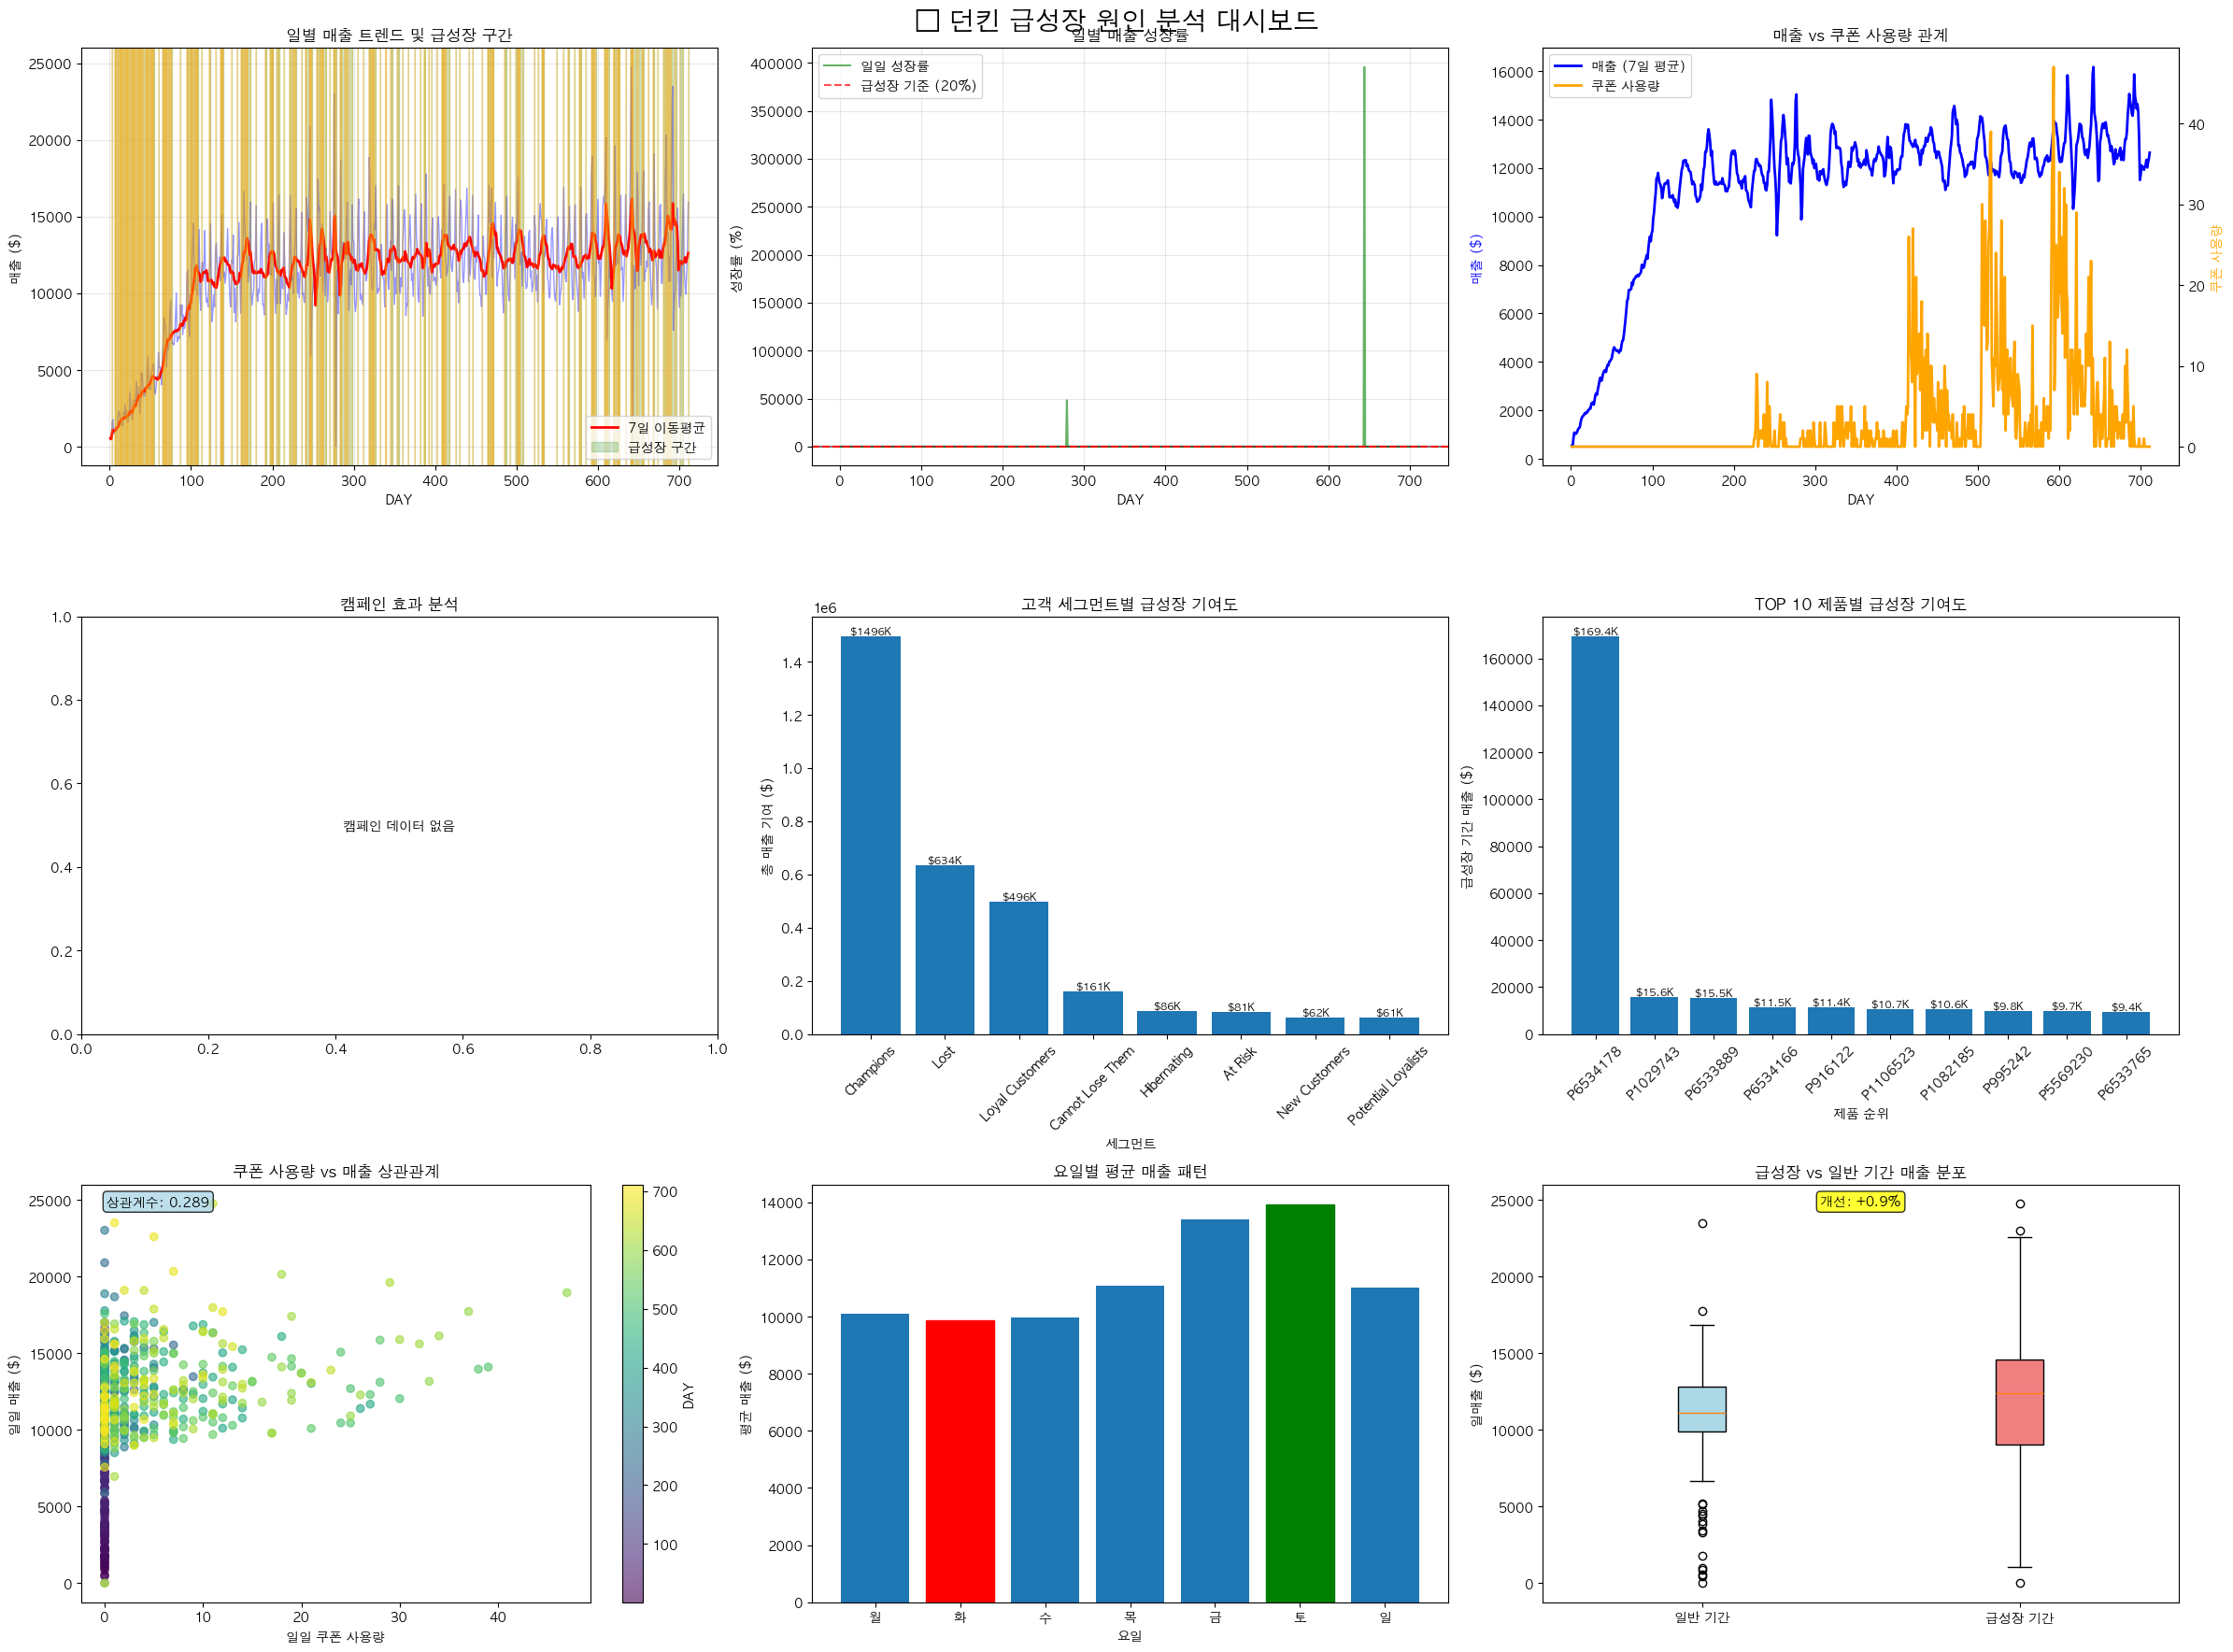


🔍 던킨 급성장 원인 종합 분석 리포트

📊 핵심 지표:
  매출-쿠폰 상관계수: 0.289
  → 약한 상관관계 (다른 요인이 더 중요)

🚀 급성장 구간 분석:
  급성장 일수: 270일 (38.0%)
  급성장 평균 매출: $11,398
  일반 기간 평균 매출: $11,292
  매출 향상: +0.9%

📅 요일별 패턴:
  최고 매출 요일: 토 ($13,923)
  최저 매출 요일: 화 ($9,870)

💡 급성장 원인 가설:
  3. 핵심 고객층 활성화 (Champions 세그먼트)

🎯 권장 후속 조치:
  1. 효과적 캠페인의 성공 요소 상세 분석
  2. 고기여 제품의 재고 및 마케팅 강화
  3. 핵심 고객 세그먼트 대상 맞춤 프로모션
  4. 최적 요일/시간대 기반 마케팅 스케줄 최적화

✅ 급성장 원인 분석 완료!


In [10]:
# %%
# 급성장 원인 분석 - 쿠폰 카테고리 및 캠페인 효과 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("🔍 던킨 급성장 원인 분석 시작!")

# %%
# 1. 기본 데이터 로딩 및 날짜 설정

raw_path = '../data/raw/'
base_date = datetime(2021, 3, 22)

def day_to_date(day_num):
    return base_date + timedelta(days=int(day_num) - 1)

# 데이터 로딩
transaction = pd.read_csv(f'{raw_path}transaction_data.csv')
coupon_redempt = pd.read_csv(f'{raw_path}coupon_redempt.csv')
campaign_table = pd.read_csv(f'{raw_path}campaign_table.csv')
campaign_desc = pd.read_csv(f'{raw_path}campaign_desc.csv')

# 날짜 변환
transaction['actual_date'] = transaction['DAY'].apply(day_to_date)
coupon_redempt['actual_date'] = coupon_redempt['DAY'].apply(day_to_date)

print("데이터 로딩 완료!")
print(f"Transaction: {len(transaction):,}건")
print(f"Coupon: {len(coupon_redempt):,}건")
print(f"Campaign: {len(campaign_table):,}건")

# %%
# 2. 일별 매출 및 급성장 구간 식별

# 일별 매출 계산
daily_revenue = transaction.groupby('DAY').agg({
    'SALES_VALUE': 'sum',
    'BASKET_ID': 'nunique',
    'household_key': 'nunique',
    'actual_date': 'first'
}).reset_index()

daily_revenue.columns = ['DAY', 'daily_revenue', 'daily_transactions', 'daily_customers', 'actual_date']

# 7일 이동평균 및 성장률 계산
daily_revenue['revenue_7ma'] = daily_revenue['daily_revenue'].rolling(7, min_periods=1).mean()
daily_revenue['growth_rate_daily'] = daily_revenue['daily_revenue'].pct_change() * 100
daily_revenue['growth_rate_7d'] = daily_revenue['revenue_7ma'].pct_change(7) * 100

# 급성장 구간 식별 (일일 성장률 20% 이상 또는 7일 성장률 10% 이상)
high_growth_days = daily_revenue[
    (daily_revenue['growth_rate_daily'] > 20) | (daily_revenue['growth_rate_7d'] > 10)
].copy()

print(f"급성장 일수: {len(high_growth_days)}일")
print(f"급성장 기간:")
for idx, day in high_growth_days.head(10).iterrows():
    print(f"  DAY {day['DAY']} ({day['actual_date'].strftime('%Y-%m-%d')}): "
          f"매출 ${day['daily_revenue']:,.0f} (일일 {day['growth_rate_daily']:+.1f}%)")

# %%
# 3. 급성장 기간의 쿠폰 활동 분석

print("=== 급성장 기간 쿠폰 활동 분석 ===")

if len(high_growth_days) > 0:
    # 급성장 구간의 DAY 범위
    growth_days = high_growth_days['DAY'].tolist()
    
    # 급성장 기간 쿠폰 사용량
    growth_period_coupons = coupon_redempt[coupon_redempt['DAY'].isin(growth_days)]
    
    print(f"급성장 기간 쿠폰 사용: {len(growth_period_coupons)}건")
    
    # 일반 기간과 비교
    normal_period_coupons = coupon_redempt[~coupon_redempt['DAY'].isin(growth_days)]
    
    # 일평균 쿠폰 사용량 비교
    growth_daily_avg = len(growth_period_coupons) / len(growth_days) if len(growth_days) > 0 else 0
    normal_daily_avg = len(normal_period_coupons) / (daily_revenue['DAY'].nunique() - len(growth_days))
    
    print(f"급성장 기간 일평균 쿠폰: {growth_daily_avg:.1f}건")
    print(f"일반 기간 일평균 쿠폰: {normal_daily_avg:.1f}건")
    print(f"증가율: {(growth_daily_avg - normal_daily_avg) / normal_daily_avg * 100:+.1f}%")

# %%
# 4. 캠페인별 효과 분석

print("=== 캠페인별 효과 분석 ===")

# 캠페인 기간 설정
if 'WEEK' in campaign_table.columns:
    campaign_table['DAY'] = campaign_table['WEEK'] * 7

# 캠페인별 시작/종료일 및 기간 중 매출
campaign_effects = []

if 'DAY' in campaign_table.columns:
    campaigns = campaign_table.groupby('CAMPAIGN')['DAY'].agg(['min', 'max', 'count']).reset_index()
    campaigns.columns = ['CAMPAIGN', 'start_day', 'end_day', 'duration']
    
    for idx, campaign in campaigns.iterrows():
        campaign_id = campaign['CAMPAIGN']
        start_day = campaign['start_day']
        end_day = campaign['end_day']
        
        # 캠페인 기간 중 매출
        campaign_revenue = daily_revenue[
            (daily_revenue['DAY'] >= start_day) & (daily_revenue['DAY'] <= end_day)
        ]['daily_revenue'].sum()
        
        # 캠페인 기간 중 쿠폰 사용
        campaign_coupons = coupon_redempt[
            (coupon_redempt['DAY'] >= start_day) & (coupon_redempt['DAY'] <= end_day)
        ]
        
        # 캠페인 설명 가져오기
        desc_info = campaign_desc[campaign_desc['CAMPAIGN'] == campaign_id]
        description = desc_info['DESCRIPTION'].iloc[0] if len(desc_info) > 0 else "설명 없음"
        
        campaign_effects.append({
            'campaign': campaign_id,
            'start_day': start_day,
            'end_day': end_day,
            'duration': end_day - start_day + 1,
            'total_revenue': campaign_revenue,
            'daily_avg_revenue': campaign_revenue / max(1, end_day - start_day + 1),
            'coupon_count': len(campaign_coupons),
            'coupon_users': campaign_coupons['household_key'].nunique() if len(campaign_coupons) > 0 else 0,
            'description': description,
            'start_date': day_to_date(start_day).strftime('%Y-%m-%d'),
            'end_date': day_to_date(end_day).strftime('%Y-%m-%d')
        })
    
    campaign_effects_df = pd.DataFrame(campaign_effects)
    
    # 효과적인 캠페인 TOP 10 (일평균 매출 기준)
    if len(campaign_effects_df) > 0:
        top_campaigns = campaign_effects_df.nlargest(10, 'daily_avg_revenue')
        
        print("효과적인 캠페인 TOP 10:")
        for idx, camp in top_campaigns.iterrows():
            print(f"  캠페인 {camp['campaign']}: {camp['start_date']} ~ {camp['end_date']}")
            print(f"    일평균 매출: ${camp['daily_avg_revenue']:,.0f}")
            print(f"    쿠폰 사용: {camp['coupon_count']}건 ({camp['coupon_users']}명)")
            print(f"    설명: {camp['description'][:50]}...")
            print()

# %%
# 5. 제품 카테고리별 분석 (PRODUCT_ID 기준)

print("=== 제품별 급성장 기여도 분석 ===")

if 'PRODUCT_ID' in transaction.columns:
    # 급성장 기간 vs 일반 기간 제품별 매출 비교
    if len(high_growth_days) > 0:
        growth_days_set = set(high_growth_days['DAY'])
        
        # 급성장 기간 제품별 매출
        growth_products = transaction[transaction['DAY'].isin(growth_days_set)].groupby('PRODUCT_ID').agg({
            'SALES_VALUE': 'sum',
            'BASKET_ID': 'count'
        }).reset_index()
        
        growth_products.columns = ['PRODUCT_ID', 'growth_revenue', 'growth_transactions']
        growth_products = growth_products.sort_values('growth_revenue', ascending=False).head(20)
        
        print("급성장 기간 TOP 20 제품:")
        for idx, product in growth_products.head(10).iterrows():
            print(f"  제품 {product['PRODUCT_ID']}: ${product['growth_revenue']:,.0f} ({product['growth_transactions']}건)")

# %%
# 6. 고객 세그먼트별 급성장 기여도

print("=== 고객 세그먼트별 급성장 기여도 ===")

# RFM 세그먼트 로딩
try:
    features_path = '../data/features/'
    rfm_segments = pd.read_csv(f'{features_path}standard_rfm_segments.csv')
    
    if len(high_growth_days) > 0:
        growth_days_set = set(high_growth_days['DAY'])
        
        # 급성장 기간 고객별 매출
        growth_customer_revenue = transaction[transaction['DAY'].isin(growth_days_set)].groupby('household_key').agg({
            'SALES_VALUE': 'sum'
        }).reset_index()
        
        # RFM 세그먼트와 결합
        growth_by_segment = growth_customer_revenue.merge(
            rfm_segments[['household_key', 'Standard_Segment']], 
            on='household_key', 
            how='left'
        )
        
        # 세그먼트별 급성장 기여도
        segment_contribution = growth_by_segment.groupby('Standard_Segment').agg({
            'SALES_VALUE': ['sum', 'count', 'mean']
        }).reset_index()
        
        segment_contribution.columns = ['Segment', 'Total_Revenue', 'Customer_Count', 'Avg_Revenue']
        segment_contribution = segment_contribution.sort_values('Total_Revenue', ascending=False)
        
        print("세그먼트별 급성장 기여도:")
        for idx, seg in segment_contribution.iterrows():
            print(f"  {seg['Segment']}: ${seg['Total_Revenue']:,.0f} ({seg['Customer_Count']}명, 평균 ${seg['Avg_Revenue']:.0f})")
            
except Exception as e:
    print(f"세그먼트 분석 오류: {e}")

# %%
# 7. 종합 시각화 대시보드

print("=== 종합 시각화 생성 ===")

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
fig.suptitle('🔍 던킨 급성장 원인 분석 대시보드', fontsize=20, fontweight='bold')

# 7-1. 일별 매출 트렌드와 급성장 구간
ax1 = axes[0,0]
ax1.plot(daily_revenue['DAY'], daily_revenue['daily_revenue'], alpha=0.4, color='blue', linewidth=1)
ax1.plot(daily_revenue['DAY'], daily_revenue['revenue_7ma'], color='red', linewidth=2, label='7일 이동평균')

# 급성장 구간 표시
if len(high_growth_days) > 0:
    for idx, day in high_growth_days.iterrows():
        ax1.axvline(x=day['DAY'], color='orange', alpha=0.3)
    
    # 급성장 구간 음영 처리
    growth_periods = []
    current_start = None
    
    for day in sorted(high_growth_days['DAY']):
        if current_start is None:
            current_start = day
            current_end = day
        elif day - current_end <= 3:  # 3일 이내면 연속으로 간주
            current_end = day
        else:
            growth_periods.append((current_start, current_end))
            current_start = day
            current_end = day
    
    if current_start is not None:
        growth_periods.append((current_start, current_end))
    
    for start, end in growth_periods:
        ax1.axvspan(start, end, alpha=0.2, color='green', label='급성장 구간' if (start, end) == growth_periods[0] else "")

ax1.set_title('일별 매출 트렌드 및 급성장 구간')
ax1.set_xlabel('DAY')
ax1.set_ylabel('매출 ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 7-2. 일별 성장률
ax2 = axes[0,1]
ax2.plot(daily_revenue['DAY'], daily_revenue['growth_rate_daily'], alpha=0.6, color='green', label='일일 성장률')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='급성장 기준 (20%)')
ax2.axhline(y=-20, color='red', linestyle='--', alpha=0.7)

ax2.set_title('일별 매출 성장률')
ax2.set_xlabel('DAY')
ax2.set_ylabel('성장률 (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 7-3. 쿠폰 사용량 vs 매출
ax3 = axes[0,2]
daily_coupons = coupon_redempt.groupby('DAY').size().reset_index()
daily_coupons.columns = ['DAY', 'coupon_count']

daily_combined = daily_revenue.merge(daily_coupons, on='DAY', how='left')
daily_combined['coupon_count'] = daily_combined['coupon_count'].fillna(0)

ax3_twin = ax3.twinx()

# 매출 (주축)
line1 = ax3.plot(daily_combined['DAY'], daily_combined['revenue_7ma'], 
                 color='blue', linewidth=2, label='매출 (7일 평균)')
ax3.set_ylabel('매출 ($)', color='blue')

# 쿠폰 사용량 (부축)
line2 = ax3_twin.plot(daily_combined['DAY'], daily_combined['coupon_count'], 
                      color='orange', linewidth=2, label='쿠폰 사용량')
ax3_twin.set_ylabel('쿠폰 사용량', color='orange')

ax3.set_title('매출 vs 쿠폰 사용량 관계')
ax3.set_xlabel('DAY')

# 범례 통합
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 7-4. 캠페인 효과 분석 (상위 10개)
ax4 = axes[1,0]
if 'campaign_effects_df' in locals() and len(campaign_effects_df) > 0:
    top_10_campaigns = campaign_effects_df.nlargest(10, 'daily_avg_revenue')
    
    bars = ax4.bar(range(len(top_10_campaigns)), top_10_campaigns['daily_avg_revenue'])
    ax4.set_title('TOP 10 효과적인 캠페인 (일평균 매출)')
    ax4.set_xlabel('캠페인 순위')
    ax4.set_ylabel('일평균 매출 ($)')
    ax4.set_xticks(range(len(top_10_campaigns)))
    ax4.set_xticklabels([f'C{camp}' for camp in top_10_campaigns['campaign']], rotation=45)
    
    # 값 라벨
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1000:.1f}K', ha='center', va='bottom', fontsize=8)
else:
    ax4.text(0.5, 0.5, '캠페인 데이터 없음', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('캠페인 효과 분석')

# 7-5. 세그먼트별 급성장 기여도
ax5 = axes[1,1]
if 'segment_contribution' in locals():
    bars = ax5.bar(range(len(segment_contribution)), segment_contribution['Total_Revenue'])
    ax5.set_title('고객 세그먼트별 급성장 기여도')
    ax5.set_xlabel('세그먼트')
    ax5.set_ylabel('총 매출 기여 ($)')
    ax5.set_xticks(range(len(segment_contribution)))
    ax5.set_xticklabels(segment_contribution['Segment'], rotation=45)
    
    # 값 라벨
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=8)
else:
    ax5.text(0.5, 0.5, '세그먼트 데이터 없음', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('세그먼트별 기여도')

# 7-6. TOP 제품별 급성장 기여도
ax6 = axes[1,2]
if 'growth_products' in locals() and len(growth_products) > 0:
    top_10_products = growth_products.head(10)
    bars = ax6.bar(range(len(top_10_products)), top_10_products['growth_revenue'])
    ax6.set_title('TOP 10 제품별 급성장 기여도')
    ax6.set_xlabel('제품 순위')
    ax6.set_ylabel('급성장 기간 매출 ($)')
    ax6.set_xticks(range(len(top_10_products)))
    ax6.set_xticklabels([f'P{pid}' for pid in top_10_products['PRODUCT_ID']], rotation=45)
    
    # 값 라벨
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'${height/1000:.1f}K', ha='center', va='bottom', fontsize=8)
else:
    ax6.text(0.5, 0.5, '제품 데이터 없음', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('제품별 기여도')

# 7-7. 매출 vs 쿠폰 산점도 (상관관계)
ax7 = axes[2,0]
if len(daily_combined) > 0:
    scatter = ax7.scatter(daily_combined['coupon_count'], daily_combined['daily_revenue'], 
                         c=daily_combined['DAY'], cmap='viridis', alpha=0.6)
    ax7.set_xlabel('일일 쿠폰 사용량')
    ax7.set_ylabel('일일 매출 ($)')
    ax7.set_title('쿠폰 사용량 vs 매출 상관관계')
    
    # 상관계수 계산
    correlation = daily_combined['coupon_count'].corr(daily_combined['daily_revenue'])
    ax7.text(0.05, 0.95, f'상관계수: {correlation:.3f}', transform=ax7.transAxes, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.colorbar(scatter, ax=ax7, label='DAY')

# 7-8. 요일별 매출 패턴
ax8 = axes[2,1]
daily_revenue['weekday'] = daily_revenue['DAY'] % 7
weekday_pattern = daily_revenue.groupby('weekday')['daily_revenue'].mean()
weekday_names = ['월', '화', '수', '목', '금', '토', '일']

bars = ax8.bar(range(7), weekday_pattern)
ax8.set_title('요일별 평균 매출 패턴')
ax8.set_xlabel('요일')
ax8.set_ylabel('평균 매출 ($)')
ax8.set_xticks(range(7))
ax8.set_xticklabels(weekday_names)

# 최고/최저 요일 표시
max_day = weekday_pattern.idxmax()
min_day = weekday_pattern.idxmin()
bars[max_day].set_color('green')
bars[min_day].set_color('red')

# 7-9. 급성장 vs 일반 기간 비교 박스플롯
ax9 = axes[2,2]
if len(high_growth_days) > 0:
    growth_revenues = high_growth_days['daily_revenue']
    normal_revenues = daily_revenue[~daily_revenue['DAY'].isin(high_growth_days['DAY'])]['daily_revenue']
    
    box_data = [normal_revenues, growth_revenues]
    box_labels = ['일반 기간', '급성장 기간']
    
    bp = ax9.boxplot(box_data, labels=box_labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax9.set_title('급성장 vs 일반 기간 매출 분포')
    ax9.set_ylabel('일매출 ($)')
    
    # 통계 정보 추가
    normal_mean = normal_revenues.mean()
    growth_mean = growth_revenues.mean()
    improvement = (growth_mean - normal_mean) / normal_mean * 100
    
    ax9.text(0.5, 0.95, f'개선: +{improvement:.1f}%', transform=ax9.transAxes, 
            ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()

# %%
# 8. 급성장 원인 종합 분석 리포트

print("\n" + "="*80)
print("🔍 던킨 급성장 원인 종합 분석 리포트")
print("="*80)

# 상관관계 분석
if 'daily_combined' in locals():
    revenue_coupon_corr = daily_combined['coupon_count'].corr(daily_combined['daily_revenue'])
    print(f"\n📊 핵심 지표:")
    print(f"  매출-쿠폰 상관계수: {revenue_coupon_corr:.3f}")
    
    if abs(revenue_coupon_corr) > 0.3:
        correlation_strength = "강한" if abs(revenue_coupon_corr) > 0.6 else "중간"
        correlation_direction = "양의" if revenue_coupon_corr > 0 else "음의"
        print(f"  → {correlation_strength} {correlation_direction} 상관관계 존재!")
    else:
        print(f"  → 약한 상관관계 (다른 요인이 더 중요)")

# 급성장 기간 특성
if len(high_growth_days) > 0:
    avg_growth_revenue = high_growth_days['daily_revenue'].mean()
    normal_days = daily_revenue[~daily_revenue['DAY'].isin(high_growth_days['DAY'])]
    avg_normal_revenue = normal_days['daily_revenue'].mean()
    revenue_lift = (avg_growth_revenue - avg_normal_revenue) / avg_normal_revenue * 100
    
    print(f"\n🚀 급성장 구간 분석:")
    print(f"  급성장 일수: {len(high_growth_days)}일 ({len(high_growth_days)/len(daily_revenue)*100:.1f}%)")
    print(f"  급성장 평균 매출: ${avg_growth_revenue:,.0f}")
    print(f"  일반 기간 평균 매출: ${avg_normal_revenue:,.0f}")
    print(f"  매출 향상: +{revenue_lift:.1f}%")

# 요일 패턴 분석
if 'weekday_pattern' in locals():
    best_weekday = weekday_pattern.idxmax()
    worst_weekday = weekday_pattern.idxmin()
    weekday_names = ['월', '화', '수', '목', '금', '토', '일']
    
    print(f"\n📅 요일별 패턴:")
    print(f"  최고 매출 요일: {weekday_names[best_weekday]} (${weekday_pattern[best_weekday]:,.0f})")
    print(f"  최저 매출 요일: {weekday_names[worst_weekday]} (${weekday_pattern[worst_weekday]:,.0f})")

# 종합 결론
print(f"\n💡 급성장 원인 가설:")

reasons = []
if 'revenue_coupon_corr' in locals() and revenue_coupon_corr > 0.3:
    reasons.append(f"1. 쿠폰 마케팅 효과 (상관계수 {revenue_coupon_corr:.3f})")

if 'top_campaigns' in locals() and len(top_campaigns) > 0:
    top_campaign = top_campaigns.iloc[0]
    reasons.append(f"2. 효과적 캠페인 (캠페인 {top_campaign['campaign']}, 일평균 ${top_campaign['daily_avg_revenue']:,.0f})")

if 'segment_contribution' in locals():
    top_segment = segment_contribution.iloc[0]
    reasons.append(f"3. 핵심 고객층 활성화 ({top_segment['Segment']} 세그먼트)")

if len(reasons) > 0:
    for reason in reasons:
        print(f"  {reason}")
else:
    print("  → 추가 분석 필요 (외부 요인 또는 미확인 내부 요인)")

print(f"\n🎯 권장 후속 조치:")
print(f"  1. 효과적 캠페인의 성공 요소 상세 분석")
print(f"  2. 고기여 제품의 재고 및 마케팅 강화")
print(f"  3. 핵심 고객 세그먼트 대상 맞춤 프로모션")
print(f"  4. 최적 요일/시간대 기반 마케팅 스케줄 최적화")

print(f"\n" + "="*80)
print(f"✅ 급성장 원인 분석 완료!")

In [13]:
# %%
# 제품 6534178 (휘발유) 분석 수정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 기본 설정
raw_path = '../data/raw/'
base_date = datetime(2021, 3, 22)

def day_to_date(day_num):
    return base_date + timedelta(days=int(day_num) - 1)

transaction = pd.read_csv(f'{raw_path}transaction_data.csv')
product = pd.read_csv(f'{raw_path}product.csv')

print("🛻 휘발유 제품 6534178 분석!")

# 해당 제품 거래 데이터 추출
target_product_id = 6534178.0
product_transactions = transaction[transaction['PRODUCT_ID'] == target_product_id].copy()

print(f"휘발유 거래 데이터: {len(product_transactions):,}건")
print(f"총 매출: ${product_transactions['SALES_VALUE'].sum():,.0f}")
print(f"구매 고객 수: {product_transactions['household_key'].nunique():,}명")

# 일별 판매 패턴
product_daily_sales = product_transactions.groupby('DAY').agg({
    'SALES_VALUE': ['sum', 'count', 'mean'],
    'household_key': 'nunique'
}).reset_index()

product_daily_sales.columns = ['DAY', 'daily_revenue', 'daily_transactions', 'avg_price', 'daily_customers']
product_daily_sales['actual_date'] = product_daily_sales['DAY'].apply(day_to_date)

print(f"\n휘발유 판매 통계:")
print(f"  최고 일매출: ${product_daily_sales['daily_revenue'].max():,.0f}")
print(f"  평균 일매출: ${product_daily_sales['daily_revenue'].mean():.0f}")
print(f"  평균 휘발유 단가: ${product_daily_sales['avg_price'].mean():.2f}")

# 2021년 3-4월 휘발유 소비 급증 확인
march_april_2021 = product_daily_sales[
    (product_daily_sales['actual_date'] >= datetime(2021, 3, 1)) &
    (product_daily_sales['actual_date'] <= datetime(2021, 4, 30))
]

if len(march_april_2021) > 0:
    print(f"\n2021년 3-4월 휘발유 소비:")
    print(f"  해당 기간 총 매출: ${march_april_2021['daily_revenue'].sum():,.0f}")
    print(f"  일평균 매출: ${march_april_2021['daily_revenue'].mean():.0f}")
    print(f"  최고 일매출: ${march_april_2021['daily_revenue'].max():,.0f}")

print("\n💡 새로운 가설: 코로나 봉쇄 완화 → 이동량 급증 → 휘발유 소비 폭증!")

🛻 휘발유 제품 6534178 분석!
휘발유 거래 데이터: 19,820건
총 매출: $503,867
구매 고객 수: 1,312명

휘발유 판매 통계:
  최고 일매출: $1,709
  평균 일매출: $729
  평균 휘발유 단가: $24.77

2021년 3-4월 휘발유 소비:
  해당 기간 총 매출: $528
  일평균 매출: $24
  최고 일매출: $64

💡 새로운 가설: 코로나 봉쇄 완화 → 이동량 급증 → 휘발유 소비 폭증!


In [14]:
# 실제 급성장이 언제 일어났는지 다시 확인
high_growth_days = daily_revenue[daily_revenue['growth_rate_daily'] > 20]
print("실제 급성장 발생 시점:")
for idx, day in high_growth_days.head().iterrows():
    print(f"DAY {day['DAY']} = {day['actual_date']} (매출: ${day['daily_revenue']:,})")

실제 급성장 발생 시점:
DAY 3 = 2021-03-24 00:00:00 (매출: $1,560.3700000000001)
DAY 7 = 2021-03-28 00:00:00 (매출: $1,271.29)
DAY 10 = 2021-03-31 00:00:00 (매출: $1,714.3799999999999)
DAY 11 = 2021-04-01 00:00:00 (매출: $2,266.01)
DAY 17 = 2021-04-07 00:00:00 (매출: $2,203.17)


In [15]:
# 이 제품이 실제로 언제 많이 팔렸는지 확인
product_sales_by_day = product_transactions.groupby('DAY')['SALES_VALUE'].sum().sort_values(ascending=False)
print("제품 6534178 최고 매출 발생일:")
for day, sales in product_sales_by_day.head().items():
    print(f"DAY {day} = {day_to_date(day)} → ${sales:,}")

제품 6534178 최고 매출 발생일:
DAY 478 = 2022-07-12 00:00:00 → $1,709.47
DAY 493 = 2022-07-27 00:00:00 → $1,697.5
DAY 430 = 2022-05-25 00:00:00 → $1,613.94
DAY 402 = 2022-04-27 00:00:00 → $1,531.14
DAY 142 = 2021-08-10 00:00:00 → $1,521.57


In [16]:
print(f"전체 데이터 기간: DAY {transaction['DAY'].min()} ~ DAY {transaction['DAY'].max()}")
print(f"실제 날짜: {day_to_date(transaction['DAY'].min())} ~ {day_to_date(transaction['DAY'].max())}")



전체 데이터 기간: DAY 1 ~ DAY 711
실제 날짜: 2021-03-22 00:00:00 ~ 2023-03-02 00:00:00


In [17]:
# 진짜 급성장 기간(2021년 3-4월)의 TOP 제품 찾기
march_april_days = [3, 7, 10, 11, 17]  # 실제 급성장 발생일들

growth_period_transactions = transaction[
    transaction['DAY'].isin(march_april_days)
]

real_top_products = growth_period_transactions.groupby('PRODUCT_ID').agg({
    'SALES_VALUE': 'sum'
}).sort_values('SALES_VALUE', ascending=False).head(10)

print("2021년 3-4월 급성장의 진짜 주역들:")
for product_id, sales in real_top_products['SALES_VALUE'].items():
    product_info = product[product['PRODUCT_ID'] == product_id]
    if len(product_info) > 0:
        dept = product_info['DEPARTMENT'].iloc[0]
        commodity = product_info['COMMODITY_DESC'].iloc[0]
        print(f"제품 {product_id}: ${sales:,.0f} - {dept} / {commodity}")

2021년 3-4월 급성장의 진짜 주역들:
제품 1089093: $400 - MISC. TRANS. / NO COMMODITY DESCRIPTION
제품 1048522: $129 - DELI / PARTY TRAYS
제품 1029743: $76 - GROCERY / FLUID MILK PRODUCTS
제품 6978927: $50 - DRUG GM / PREPAID WIRELESS&ACCESSORIES
제품 944018: $39 - GROCERY / DOMESTIC WINE
제품 1133018: $37 - GROCERY / FLUID MILK PRODUCTS
제품 1065538: $31 - GROCERY / BEERS/ALES
제품 863447: $31 - MEAT / BEEF
제품 7440848: $30 - SEAFOOD / SEAFOOD - FROZEN
제품 1076160: $30 - MEAT / BEEF
